# Use wateRinfo package to understand eel behaviour in the Scheldt river

## Introduction

The [Fish acoustic receiver network](http://lifewatch.be/en/fish-acoustic-receiver-network) is a Lifewatch supported infrastructure to track the distribution, movements and habitat use of migratory fish. Among other species, we tag and study eels to get data-based knowledge about their migration behaviour. Using this information we can propose effective policy measures to support this criticially endangered species.

Interested in the fascinating live of the eel and eager to understand what we're talking about when mentioning `transmitters` and `receivers`? Check out the animated video starring affiliated Phd student Pieterjan Verhelst:

[![Tagging research on eel in Belgium](https://img.youtube.com/vi/7YQVgl3QPyY/0.jpg)](https://www.youtube.com/watch?v=7YQVgl3QPyY)

We received an interested subset of the fish tracking data from Pieterjan about two eels to do some explorative data analysis with and show a research application of the [wateRinfo R package](https://inbo.github.io/wateRinfo/) we developed last year. 

## Eel tracking data

For now, let's just start with the tracking data of the eels itself and do a quick check on the favorite places to hang out in the Scheldt estuary of two of our tagged eels. Reading in the CSV data set with the `readr` package, which is part of the `tidyverse` ecosystem:

In [192]:
library(tidyverse)

In [193]:
eels <- read_csv("..//files//eels.csv", col_types = cols())

A quick exploration of the first lines of the eels tracking data:

In [195]:
head(eels)

Date,Transmitter,Receiver,latitude,longitude,station,Arrival,Departure,Detections,residencetime
2016-10-11,A69-1601-52622,VR2W-112287,51.00588,3.77876,s-2,2016-10-11 17:41:00,2016-10-11 18:14:00,42,1980
2016-10-11,A69-1601-52622,VR2W-112297,51.00164,3.85695,s-Wetteren,2016-10-11 20:08:00,2016-10-11 20:25:00,10,1020
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 03:06:00,2016-10-12 10:15:00,175,25740
2016-10-12,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-12 14:50:00,2016-10-12 23:11:00,185,30060
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 15:34:00,2016-10-13 19:22:00,70,13680
2016-10-13,A69-1601-52622,VR2W-115438,51.01680,3.92527,s-Wichelen,2016-10-13 03:10:00,2016-10-13 11:12:00,121,28920


We have the residence time as an available column, so we can derive their *favourite place to hang out* by calculating the total residence time around each receiver:

In [196]:
residence <- eels %>% 
    group_by(Receiver, latitude, longitude, Transmitter) %>%
    summarise(total_residence = sum(residencetime))

As we are dealing with spatial data and we have the coordinates of each receiver, let's use the power of the [R leaflet package](https://rstudio.github.io/leaflet/) to plot the total residence time of both on a map, each having it's own color:

In [214]:
tag_colors <- colorFactor(c("#e66101", "#5e3c99"), eels$Transmitter)

m <- leaflet(data = residence, width = 600, height = 400) %>%
  addTiles() %>%  
  addCircleMarkers(~longitude, ~latitude, popup = ~Receiver, fillColor = ~tag_colors(Transmitter),
                   radius = ~total_residence/3600, stroke=FALSE, fillOpacity = 0.6) %>%
  addLegend(values = ~Transmitter, pal = tag_colors)
m

HTML widgets cannot be represented in plain text (need html)

Apparently, the eel with transmitter `A69-1601-52622` mainly like to be around Hamme and between Wetteren and Wichelen., whereas eel `A69-1601-52644` likes to swim around along the different sections of the Scheldt river.

Nevertheless, we miss the temporal effect in the previous figure. Adding the temporal component is required to get more insight in the behaviour of the eel, prefereably in a single graph, with the x-axis time and the y-axis the different locations in the Scheldt estuary instead of the longitude/latitude coordinates. The latter requires us to represent the Scheldt river from Ghent/Merelbeke until the sea as a straight line, with the distances of each receiver relative to the sea.

To do so, we selected receiver `ws-DL7` which is close to the sea as a reference point. For each receiver, the distance from to the reference receiver inside the river is calculated by the `costDistance` function. See [this notebook ADD LINK](ADD LINK) for the details of the calculation, providing an overview table `distance_from_sea.csv` as output:

In [223]:
distance_from_sea <- read_csv("../files/distance_from_sea.csv", col_types = cols())
head(distance_from_sea)

reference_station,station,distance_to_refence_station,station_id,longitude,latitude,station_type
ws-DL7,ws-DL7,0.000,VR2W-123820,3.475013,51.47134,receiver
ws-DL7,ws-DL9,1233.051,VR2W-127727,3.488680,51.46584,receiver
ws-DL7,ws-TRAWL,3877.957,VR2W-123817,3.470347,51.43778,receiver
ws-DL7,ws-13,19152.863,VR2W-120876,3.708088,51.40719,receiver
ws-DL7,ws-PVTSS,19457.817,VR2W-120873,3.708913,51.40181,receiver
ws-DL7,ws-4,20159.991,VR2W-120882,3.715344,51.39704,receiver


Adding these distances to the eels tracking data set:

In [224]:
eels <- eels %>%
    left_join(distance_from_sea, by = "station")

The receiver stations along the Scheldt River each have a unique code, but for convenience, we'll provide a translation to nearby municipalities, as this makes the interpretation of figures much easier. Loading the mapping from file and adding the distances from the reference station to this mapping:

In [226]:
station_municipality <- read_csv("../files/link_station_municipality.csv", col_types = cols())
station_municipality <- station_municipality %>% 
    left_join(eels %>% select(station, distance_to_refence_station) %>% 
              distinct(), by = "station")

We have now anough information to the tracks in space and time on a 2D-graph. `ggplot2` shines in this type of plots, so let's give it a go:

In [237]:
library(lubridate)

In [238]:
options(repr.plot.width=6, repr.plot.height=6)

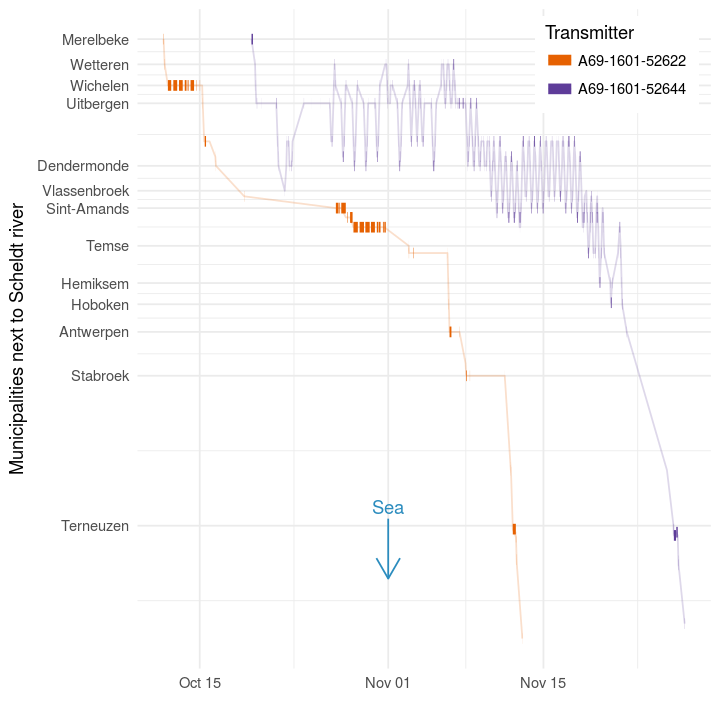

In [239]:
ggplot(eels, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, 
                 yend = distance_to_refence_station,
                 color = Transmitter)) +
    geom_segment(size = 3) + xlab("") + ylab("") +
    geom_line(data = eels, aes(x = Arrival, y = distance_to_refence_station), 
              alpha = 0.2, size = 0.5) +
    scale_y_continuous("Municipalities next to Scheldt river", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    scale_color_manual(values = c("#e66101", "#5e3c99"), guide = guide_legend()) +
    annotate("text", x = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.22, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-01"), xend = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
                 arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal() +
    theme(legend.position = c(.98, .99),
          legend.justification = c("right", "top"),
          legend.box.just = "right",
          legend.margin = margin(6, 6, 6, 6),
          legend.background =  element_rect(fill="white", color = "transparent"))

In [ ]:
For both eels, we pick up the signal around Ghent/Merelbeke,...

### Tidal data from Waterinfo

In [25]:
library(wateRinfo)

Using the [tidal stations overview](https://github.com/inbo/wateRinfo/files/1483458/tij_all_identifiers.txt) as discussed on the wateRinfo [GitHub Issues](https://github.com/inbo/wateRinfo/issues/11#issuecomment-345339779), but excluding some none-Scheldt river identifiers:

In [26]:
ts_id_tide <- read_csv("../files/scheldt_tide_waterinfo_identifiers.csv", col_types = cols()) %>%
    filter(grepl(".*10min.base", ts_name)) %>% # use 10min based data
    filter(!station_name %in% c("Walem tij/Rupel", "Duffel-sluis tij", "Lier Molbrug tij/Nete",
                           "Kessel tij/Grote Nete", "Emblem tij/Kleine Nete", 
                           "Mechelen Benedensluis tij/Dijle", "Mechelen Stuw Opwaarts tij/Dijle",
                           "Hombeek tij/Zenne", "Zemst tij/Zenne", "Gentbrugge tij/Zeeschelde",
                           "Waasmunster Manta tij/Durme")) # exclude nonte-scheldt stations

Download the data of these stations for the period equivalent to the data period of the eels tracks data:

In [27]:
tidal_data <- read_csv("../files/tidal_data.csv", col_types = cols())

In [28]:
tidal_data <- tidal_data %>%
    left_join(distance_from_sea, by = c("station_name" = "station"))

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

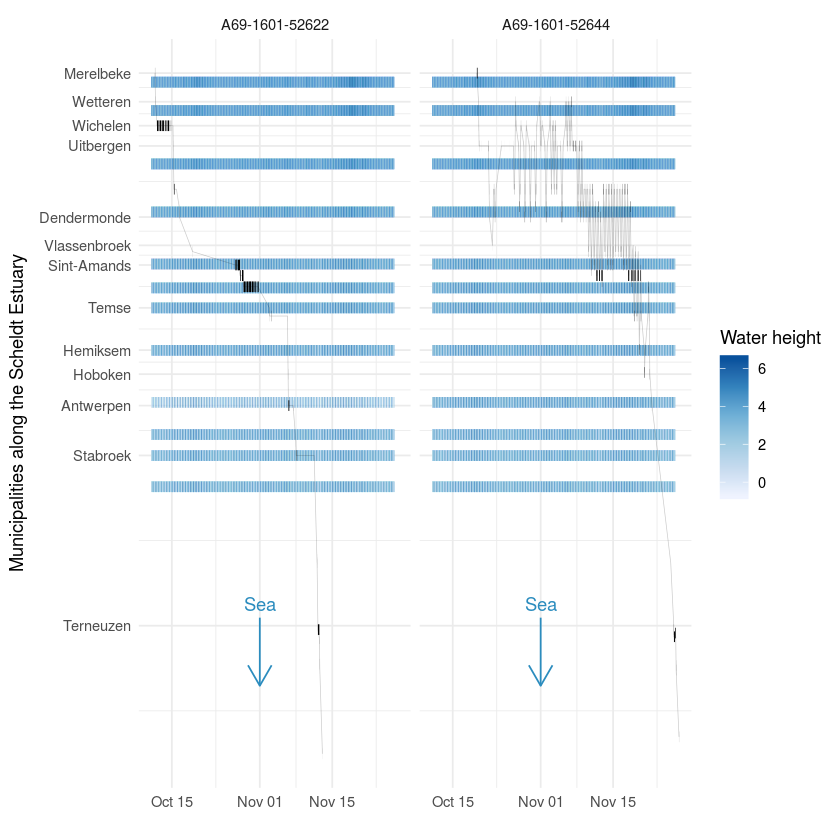

In [29]:
ggplot() +
    geom_segment(data = tidal_data, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_segment(data = eels, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 3) +
    geom_line(data = eels, aes(x = Arrival, y = distance_to_refence_station), 
              alpha = 0.2, size = 0.2) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities along the Scheldt Estuary", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    annotate("text", x = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.22, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-01"), xend = as_datetime("2016-11-01"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
                 arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal() + facet_wrap(~Transmitter)

#ggsave(filename = "eels_behavior_1.png", dpi = 300)

In [ ]:
wardpal <- colorFactor(c("#2b8cbe", "#808080"), distance_from_sea$station_type)
m <- leaflet(data = distance_from_sea, width = 600, height = 400) %>%
  addTiles() %>%  
  addCircleMarkers(~longitude, ~latitude, popup = ~station, 
                   fillColor = ~wardpal(station_type), stroke=FALSE, fillOpacity = 0.6)  "#2b8cbe"
m

## Focus on tag A69-1601-52644

Intermezzo: peaks to intervals:

In [30]:
ts_id_high_tide <- read_csv("../files/scheldt_tide_waterinfo_identifiers.csv", col_types = cols()) %>%
    filter(grepl(".HWLW.base", ts_name)) %>% # use 10min based data
    filter(station_name == "Dendermonde tij/Zeeschelde")

peaks_tide <- ts_id_high_tide %>% group_by(ts_id) %>%
    do(get_timeseries_tsid(.$ts_id,
                           from = min(eels$Date),
                           to = max(eels$Date),
                           datasource = 2)) %>%
    ungroup() %>%
    left_join(ts_id_high_tide, by = "ts_id") %>%
    select(Timestamp, Value, station_no, station_name) %>%
    rename(tide_value = Value)

In [31]:
peaks_tide %>%
    mutate(high_water = if_else(tide_value > 3, "end", "start")) %>%
    mutate(tide_id = sort(rep(seq(1, nrow(peaks_tide)/2 + 1), 2))[1:nrow(peaks_tide)]) %>%
    select(Timestamp, tide_id, high_water) %>%
    spread(key = high_water, value = Timestamp) -> tide_periods

In [32]:
head(tide_periods)

tide_id,end,start
1,2016-10-11 11:23:00,2016-10-11 05:50:00
2,2016-10-12 00:21:00,2016-10-11 18:49:00
3,2016-10-12 12:58:00,2016-10-12 07:38:00
4,2016-10-13 01:32:00,2016-10-12 20:27:00
5,2016-10-13 14:05:00,2016-10-13 08:55:00
6,2016-10-14 02:35:00,2016-10-13 21:35:00


### period of tidal follow - ggforce

In [33]:
library(ggforce)

In [34]:
options(repr.plot.width=12, repr.plot.height=8)

Warning message:
“Removed 4 rows containing missing values (geom_segment).”

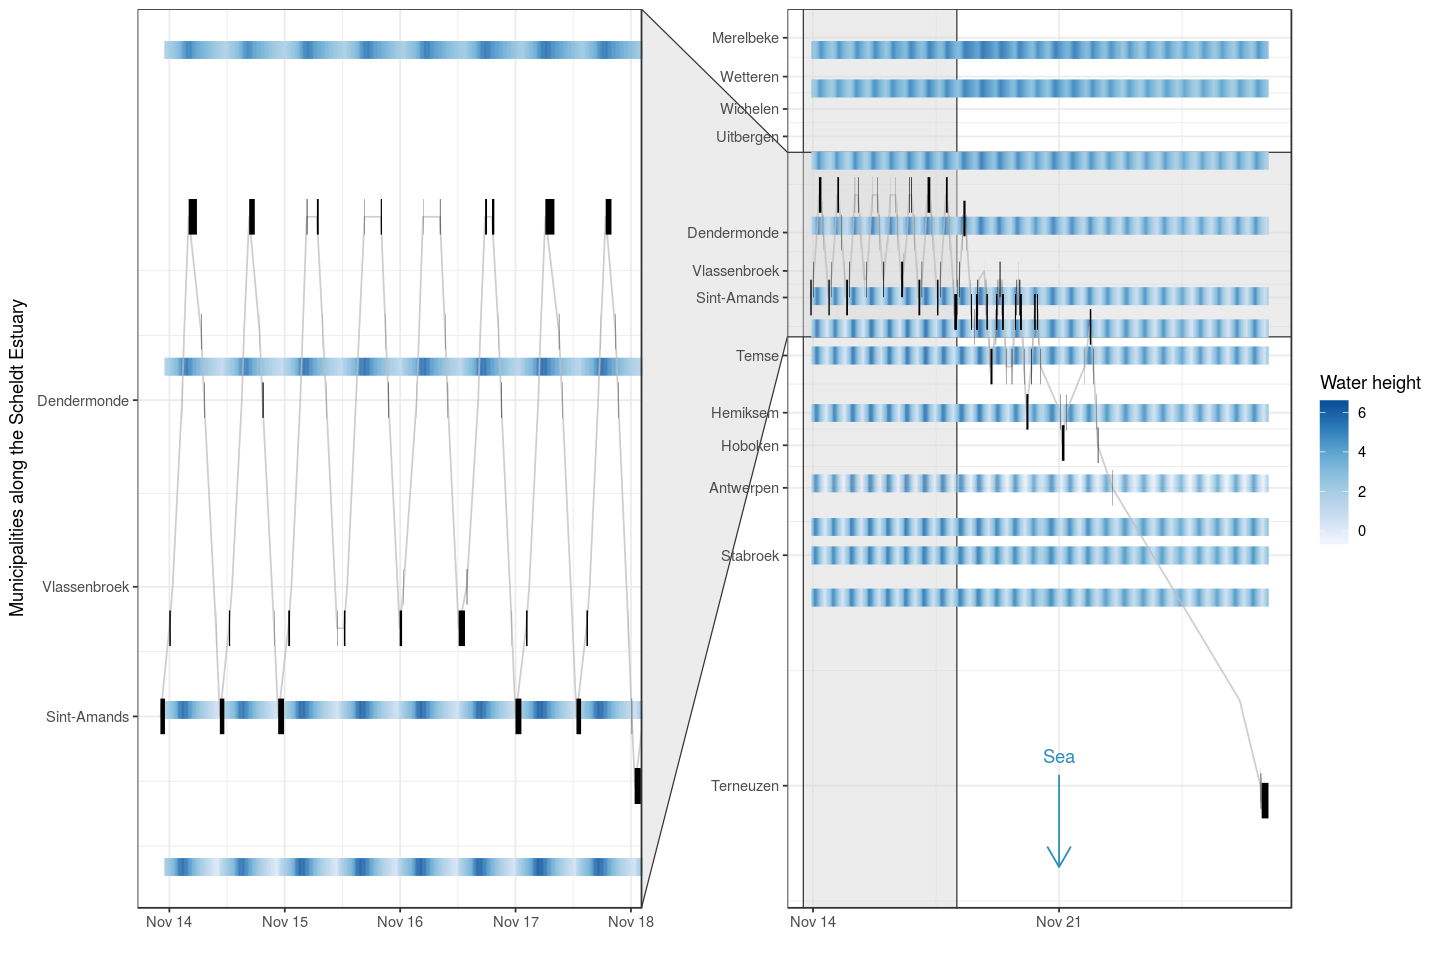

In [35]:
start_moment <- "2016-11-14"
end_moment <- "2016-11-27"

eels_subset <- eels %>% filter(Departure >= start_moment, 
                               Arrival <= end_moment, 
                               Transmitter == "A69-1601-52644") %>%
    mutate(zoom_it_x = if_else(Arrival <= "2016-11-18", TRUE, FALSE))

tidal_data %>% filter(Timestamp >= start_moment, Timestamp <= end_moment) -> tidal_data_subset

tidal_data_subset <- tidal_data_subset %>%
    mutate(zoom_it_y = if_else(station_name %in% c("Dendermonde tij/Zeeschelde", 
                                                 "Sint-Amands tij/Zeeschelde",
                                                 "Tielrode tij/Durme",
                                                 "Schoonaarde tij/Zeeschelde"), TRUE, FALSE))

ggplot() +
    geom_segment(data = tidal_data_subset, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 5) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_line(data = eels_subset, aes(x = Arrival, 
                                      y = distance_to_refence_station),
              alpha = 0.75, color = "grey") +
    geom_segment(data = eels_subset, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 10) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities along the Scheldt Estuary", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    annotate("text", x = as_datetime("2016-11-21"),
             y = max(eels$distance_to_refence_station) * 0.22, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-21"), xend = as_datetime("2016-11-21"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
                 arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    facet_zoom(y = zoom_it_y == TRUE,
               x = zoom_it_x == TRUE,
               zoom.size = 1,
               show.area = TRUE) +
    theme_bw()
#ggsave(filename = "eels_behavior_3.png", dpi = 300)

Without ggforce

In [36]:
tide_periods %>% head()

tide_id,end,start
1,2016-10-11 11:23:00,2016-10-11 05:50:00
2,2016-10-12 00:21:00,2016-10-11 18:49:00
3,2016-10-12 12:58:00,2016-10-12 07:38:00
4,2016-10-13 01:32:00,2016-10-12 20:27:00
5,2016-10-13 14:05:00,2016-10-13 08:55:00
6,2016-10-14 02:35:00,2016-10-13 21:35:00


In [156]:
?geom_line

geom_path {ggplot2},R Documentation
mapping,"Set of aesthetic mappings created by aes() or aes_(). If specified and inherit.aes = TRUE (the default), it is combined with the default mapping at the top level of the plot. You must supply mapping if there is no plot mapping."
data,"The data to be displayed in this layer. There are three options: If NULL, the default, the data is inherited from the plot data as specified in the call to ggplot(). A data.frame, or other object, will override the plot data. All objects will be fortified to produce a data frame. See fortify() for which variables will be created. A function will be called with a single argument, the plot data. The return value must be a data.frame., and will be used as the layer data."
stat,"The statistical transformation to use on the data for this layer, as a string."
position,"Position adjustment, either as a string, or the result of a call to a position adjustment function."
...,"other arguments passed on to layer(). These are often aesthetics, used to set an aesthetic to a fixed value, like color = ""red"" or size = 3. They may also be parameters to the paired geom/stat."
lineend,"Line end style (round, butt, square)"
linejoin,"Line join style (round, mitre, bevel)"
linemitre,Line mitre limit (number greater than 1)
arrow,"Arrow specification, as created by grid::arrow()"
na.rm,"If FALSE, the default, missing values are removed with a warning. If TRUE, missing values are silently removed."


In [162]:
start_moment <- "2016-11-14"
end_moment <- "2016-11-27"

eels_subset <- eels %>% filter(Departure >= start_moment, 
                               Arrival <= end_moment, 
                               Transmitter == "A69-1601-52644")

tidal_data_subset <- tidal_data %>% filter(Timestamp >= start_moment, 
                                           Timestamp <= end_moment)

tide_periods_subset <- tide_periods %>% filter(start >= start_moment, end <= end_moment)

ggplot() +
    geom_rect(data = tide_periods_subset, 
              aes(xmin = start, xmax = end, ymin = 0, ymax = Inf), 
              alpha = 0.05) +
    geom_segment(data = tidal_data_subset, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 5) + 
    scale_color_distiller("Water height\n(m TAW)", type = "seq", palette = "Blues", direction = 1) +
    geom_line(data = eels_subset, aes(x = Arrival, 
                                      y = distance_to_refence_station),
              alpha = 0.9, color = "grey", linetype = "dashed", size = 0.5) +
    geom_segment(data = eels_subset, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 3) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities along the Scheldt Estuary", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    scale_x_datetime(date_labels = "%Y-%m-%d",
                     date_breaks = "7 days") +
    annotate("text", x = as_datetime("2016-11-21"),
             y = max(eels$distance_to_refence_station) * 0.22, 
             colour = "#2b8cbe", label = "Sea") +
    annotate("segment", x = as_datetime("2016-11-21"), xend = as_datetime("2016-11-21"),
             y = max(eels$distance_to_refence_station) * 0.2, 
             yend = max(eels$distance_to_refence_station) * 0.1, 
                 arrow = arrow(length = unit(0.5, "cm")), color = "#2b8cbe") +
    theme_minimal() -> tidal_tracks
#ggsave(filename = "eels_behavior_3.png", dpi = 300)

In [163]:
ggplot() +
    geom_rect(data = tide_periods_subset, 
              aes(xmin = start, xmax = end, ymin = 0, ymax = Inf), 
              alpha = 0.05) +
    geom_line(data = tidal_data_subset %>% filter(station_name == "Dendermonde tij/Zeeschelde"), 
              aes(x = Timestamp, y = Value, color = Value)) + 
    scale_x_datetime(date_labels = "%Y-%m-%d",
                     date_breaks = "7 days") +
    scale_color_distiller("Water height\n(m TAW)", type = "seq", 
                          palette = "Blues", direction = 1) +
    theme_minimal() + 
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank()) +
    ylab("Tide Dendermonde\n(m TAW)") -> tide_dendermonde

In [164]:
library(ggpubr)

In [165]:
options(repr.plot.width=8, repr.plot.height=8)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

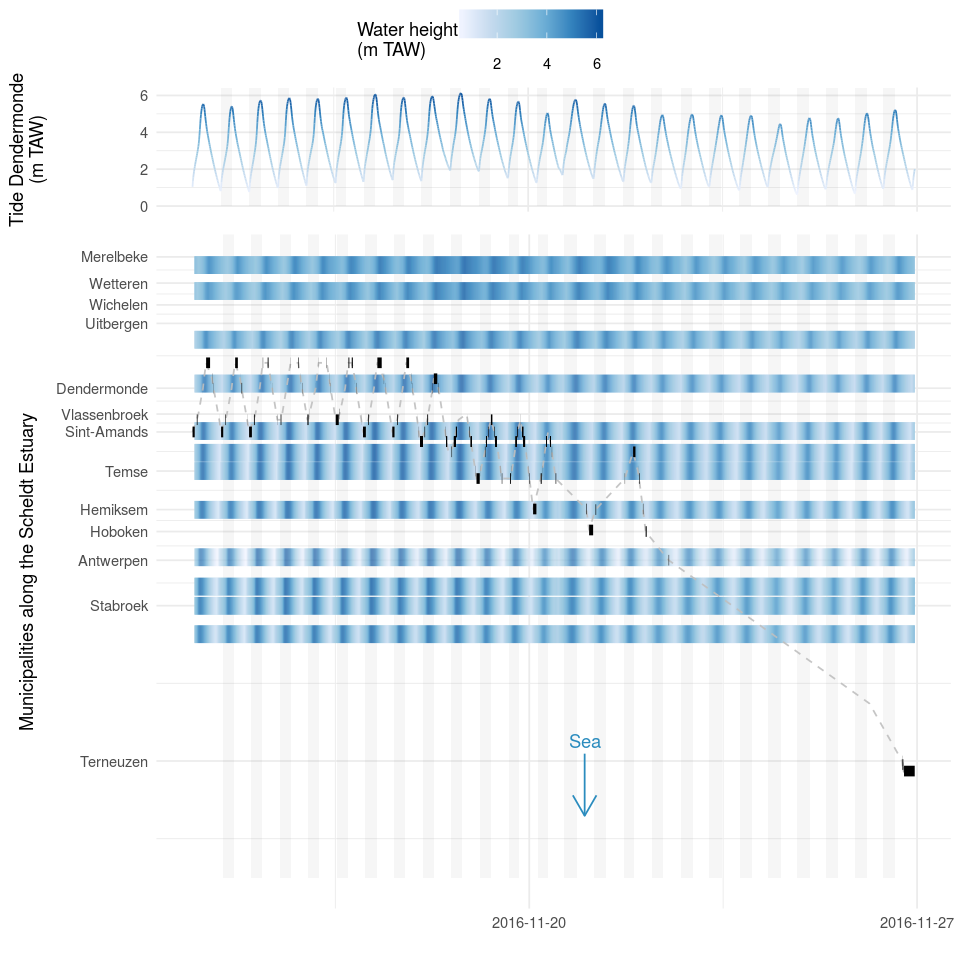

In [166]:
ggarrange(tide_dendermonde, tidal_tracks,  
          ncol = 1, nrow = 2, common.legend = TRUE,
          align = "v", heights = c(1, 5))

### small zoom using ggridges

In [86]:
library(ggridges)

In [87]:
start_moment <- "2016-11-14"
end_moment <- "2016-11-18"

In [88]:
max_zoom <- station_municipality %>% filter(municipality == "Uitbergen") %>% select(distance_to_refence_station) %>% pull()
min_zoom <- station_municipality %>% filter(municipality == "Temse") %>% select(distance_to_refence_station) %>% pull()

In [89]:
eels %>% 
    filter(Departure >= start_moment, Arrival <= end_moment, 
           Transmitter == "A69-1601-52644",
           distance_to_refence_station > min_zoom,
           distance_to_refence_station < max_zoom) -> eels_zoom
tidal_data %>% filter(Timestamp >= start_moment, 
                      Timestamp <= end_moment,
                      distance_to_refence_station > min_zoom,
                      distance_to_refence_station < max_zoom) -> tidal_data_zoom
station_municipality %>% 
    filter(distance_to_refence_station >= min_zoom,
           distance_to_refence_station <= max_zoom) -> station_municipality_zoom

In [137]:
options(repr.plot.width=6, repr.plot.height=3)

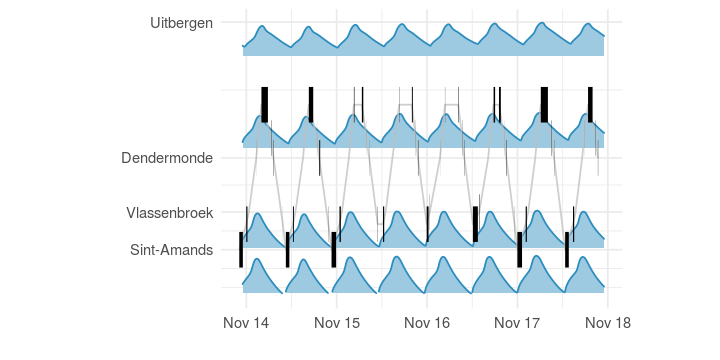

In [138]:
ggplot() +
    geom_ridgeline(data = tidal_data_zoom, 
                   aes(x = Timestamp, y = distance_to_refence_station, 
                       height = Value, group = distance_to_refence_station),
                   scale = 700, fill = "#9ecae1", color = "#2b8cbe") +
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_line(data = eels_zoom, aes(x = Arrival, y = distance_to_refence_station),
              alpha = 0.75, color = "grey", size = 0.5) +
    geom_segment(data = eels_zoom, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 10) +
    xlab("") + ylab("") +
    scale_y_continuous("", 
                       breaks = station_municipality_zoom$distance_to_refence_station,
                       labels = station_municipality_zoom$municipality) +
    theme_minimal() +
    coord_fixed(ratio = 8) +
    theme(legend.position="none")

## Focus on tag A69-1601-52644

In [92]:
start_moment <- "2016-10-15"
end_moment <- "2016-11-07"

eels %>% filter(Departure >= start_moment, Arrival <= end_moment,
                Transmitter == "A69-1601-52622") -> eels_subset
tidal_data %>% filter(Timestamp >= start_moment, Timestamp <= end_moment) -> tidal_data_subset

Warning message:
“Removed 1 rows containing missing values (geom_segment).”

Saving 6.67 x 6.67 in image
Warning message:
“Removed 1 rows containing missing values (geom_segment).”

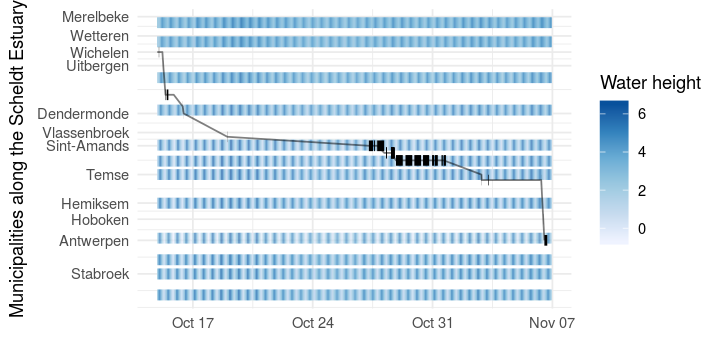

In [93]:
ggplot() +
    geom_segment(data = tidal_data_subset, aes(x = Timestamp, xend = lag(Timestamp),
                 y = distance_to_refence_station, yend = distance_to_refence_station,
                 color = Value), size = 3) + 
    scale_color_distiller("Water height", type = "seq", palette = "Blues", direction = 1) +
    geom_segment(data = eels_subset, aes(x = Arrival, xend = Departure, 
                 y = distance_to_refence_station, yend = distance_to_refence_station), 
                 size = 3) +
    geom_line(data = eels_subset, aes(x = Arrival, 
                                      y = distance_to_refence_station),
              alpha = 0.5) +
    xlab("") + ylab("") +
    scale_y_continuous("Municipalities along the Scheldt Estuary", 
                       breaks = station_municipality$distance_to_refence_station,
                       labels = station_municipality$municipality) +
    theme_minimal()
ggsave(filename = "eels_behavior_4.png", dpi = 300)

In [83]:
#ggplot(tidal_data, aes(x = Timestamp, y  = station_no, color = Value)) +
#    geom_tile()

TODO:
- mee po figuur zetten
- kaartversie maken